In [1]:
import numpy as np
import matplotlib.pyplot as plt

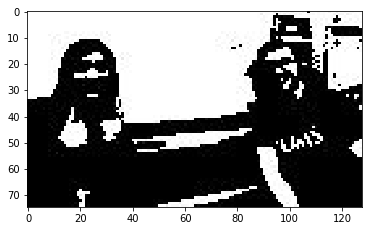

In [2]:
img = plt.imread('MLSquadBW.jpg')
imgplot = plt.imshow(img, cmap = "gray")
plt.show()

In [3]:
class NoisyImages(object):
    def __init__(self, prop, varSigma):
        self.prop = prop
        self.varSigma = varSigma
        
    def addGaussianNoise(self, im):
        im = im/255
        N = int(np.round(np.prod(im.shape)*self.prop))
        index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
        e = self.varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
        im2 = np.copy(im).astype('float')
        im2[index] += e[index]
        return im2
    
    def addSaltnPepperNoise(self, im):
        im = im/255
        N = int(np.round(np.prod(im.shape)*self.prop))
        index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
        im2 = np.copy(im)
        im2[index] = 1-im2[index]
        return im2
    

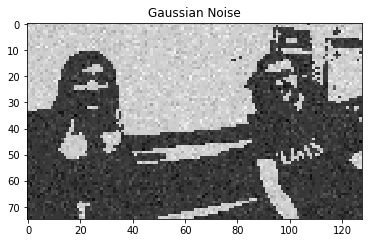

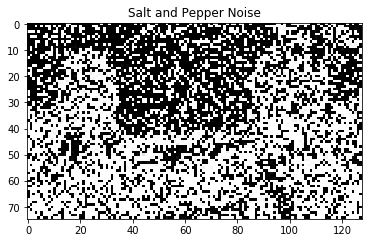

In [4]:
createNoise = NoisyImages(0.7, 0.1)

gaussianImg = createNoise.addGaussianNoise(img)
snpImg = createNoise.addSaltnPepperNoise(img)

plt.imshow(gaussianImg, cmap="gray")
plt.title("Gaussian Noise")
plt.show()

plt.imshow(snpImg, cmap="gray")
plt.title("Salt and Pepper Noise")
plt.show()

In [5]:
class HelperTools(object):    
    def neighbours(self, i, j, M, N, size=4):
        # M = size of rows (ie x), N = size of columns (ie y)
        if size == 4:
            if i == 0 and j == 0:
                n = [(0, 1), (1, 0)]
            elif i == 0 and j==N-1:
                n = [(0, N-2), (1, N-1)]
            elif i == M-1 and j == 0:
                n = [(M-1, 1), (M-2, 0)]
            elif i == M-1 and j == N-1:
                n = [(M-1, N-2), (M-2, N-1)]
            elif i == 0:
                n = [(0, j-1), (0, j+1), (1, j)]
            elif i == M-1:
                n = [(M-1, j-1), (M-1, j+1), (M-2, j)]
            elif j == 0:
                n = [(i-1, 0), (i+1, 0), (i, 1)]
            elif j == N-1:
                n = [(i-1, N-1), (i+1, N-1), (i, N-2)]
            else:
                n = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
                
        if size == 8:
            if i == 0 and j == 0:
                n = [(0, 1), (1, 0), (1, 1)]
            elif i == 0 and j == N-1:
                n = [(0, N-2), (1, N-1), (1, N-2)]
            elif i == M-1 and j == 0:
                n = [(M-1, 1), (M-2, 0), (M-2, 1)]
            elif i == M-1 and j == N-1:
                n = [(M-1, N-2), (M-2, N-1), (M-2, N-2)]
            elif i == 0:
                n = [(0, j-1), (0, j+1), (1, j), (1, j+1), (1, j-1)]
            elif i == M-1:
                n = [(M-1, j-1), (M-1, j+1), (M-2, j), (M-2, j+1), (M-2, j-1)]
            elif j == 0:
                n = [(i-1, 0), (i+1, 0), (i, 1), (i+1, 1), (i-1, 1)]
            elif j == N-1:
                n = [(i-1, N-1), (i+1, N-1), (i, N-2), (i+1, N-2), (i-1, N-2)]
            else:
                n = [(i-1, j), (i+1, j), (i, j-1), (i, j+1), (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
            
        return n

In [9]:
class ICM(object):
    def __init__(self, image):
        self.image = (image > 0.5).astype(float)
        self.T = image.shape[0]
        self.N = image.shape[1]
        self.helper = HelperTools()
        
        # Set x to be the image
        self.x = self.image + (self.image - 1)
        self.image = self.image + (self.image -1)
    
    def e0(self, t, i, calcZ=False):
        ni = self.helper.neighbours(t, i, self.T, self.N, 8)
        w = 1
        
        if calcZ:
            out1 = 0
            out2 = 0
            for j in ni:
                out1 += w*1*(self.x[j[0]][j[1]])
            for j in ni:
                out2 += w*-1*(self.x[j[0]][j[1]])
            return np.exp(out1) + np.exp(out2)
        
        out = 0
        for j in ni:
            out += w*(self.x[t][i])*(self.x[j[0]][j[1]])
        return out
    
    def lixi(self, t, i):
        cons = 2.1
        
        return cons * self.x[t][i] * self.image[t][i]
        
    def prodfunc(self, x, y, Z1, xiVal):    
        Z0 = self.e0(x, y, True)
        
        initx = self.x[x][y]
        self.x[x][y] = xiVal
        
        prodOutput = (1/Z1) * np.exp(self.lixi(x, y)) * (1/Z0) * np.exp(self.e0(x, y))
        
        self.x[x][y] = initx
        
        return prodOutput
        
    def runICMloop(self):
        change = False
        
        Z1 = np.exp(2.1) + np.exp(-2.1)
        retImg = []
        for t in range(self.T):
            row = []
            for i in range(self.N):
                if self.prodfunc(t, i, Z1, 1) >  self.prodfunc(t, i, Z1, -1):
                    if self.x[t][i] == -1:
                        change = True
                    output = 1
                else:
                    if self.x[t][i] == 1:
                        change = True
                    output = -1
                    
                row.append(output)
            retImg.append(row)
            
        self.x = retImg
                
        return np.array(retImg), change
    
    def runICM(self, maxIters=100):
        change = True
        count = 0
        while change == True and count < maxIters:
            retImg, change = self.runICMloop()
            count += 1
        
        print(count)
            
        return retImg

100


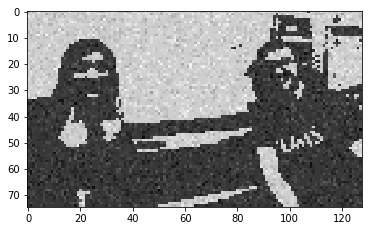

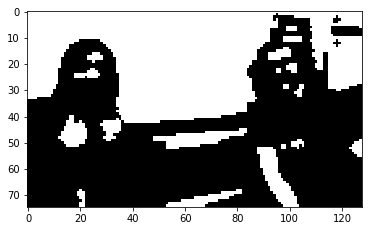

In [10]:
ICMdoer = ICM(gaussianImg)
output = ICMdoer.runICM()
plt.imshow(gaussianImg, cmap="gray")
plt.show()
plt.imshow(output, cmap="gray")
plt.show()

100


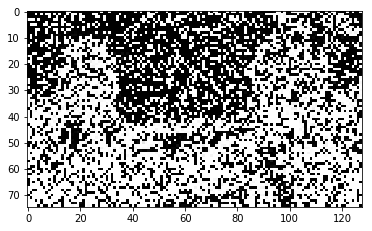

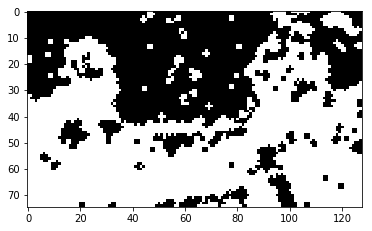

In [11]:
ICMdoer = ICM(snpImg)
output = ICMdoer.runICM()
plt.imshow(snpImg, cmap="gray")
plt.show()
plt.imshow(output, cmap="gray")
plt.show()